In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class Maze():
    def __init__(self, row=10, col=10, epsilon=0.1, gamma=0.5, lr=1, episode_len=1000, mode="Q-Learning"):
        self.row = row
        self.col = col
        self.Qvalue=np.zeros((row, col, 4))
        self.actions={"up":0,"down":1,"right":2,"left":3}
        self.epsilon=epsilon
        self.gamma=gamma
        self.lr=lr
        self.episode_len=episode_len
        self.mode= mode
        
        self.maze_frame=np.array([
            [1,0,0,0,0,0,1,1,1,1],
            [1,1,1,1,1,0,1,0,1,1],
            [1,1,1,0,1,0,1,1,1,1],
            [1,0,1,0,1,0,1,0,0,1],
            [1,0,1,0,1,0,1,0,1,1],
            [1,0,0,0,1,0,1,0,1,0],
            [1,0,1,1,1,0,1,0,1,0],
            [1,0,1,0,0,0,1,0,1,1],
            [0,1,1,1,1,1,1,0,1,1],
            [1,1,1,1,0,0,0,0,1,1],
        ], dtype=np.float32)

    def _done(self, state_row, state_col): # 종료함수
        if (9,9) == (state_row, state_col):
            return True
        else:
            return False
        
    def _get_eps_greedy_action(self, state_row, state_col, epsilon): # 행동을 선택해주는 함수
        if np.random.rand() < epsilon:
            return np.random.randint(0,4)
        else:
            return np.nanargmax(self.Qvalue[state_row][state_col]) # 가장 높은 확률의 경로

    def _get_step_reward(self, state_row, state_col, action): # 행동에 따른 reward를 찾아주는 함수
        next_state_row, next_state_col, reward = 0, 0, 0
        if action==0: # up
            next_state_row, next_state_col = state_row - 1, state_col
        elif action==1: # down
            next_state_row, next_state_col = state_row + 1, state_col
        elif action==2: # right
            next_state_row, next_state_col = state_row, state_col + 1
        elif action==3: # left
            next_state_row, next_state_col = state_row, state_col - 1
            
        if 0<=next_state_row and next_state_row<self.row and 0<=next_state_col and next_state_col<self.col: # map
            if self.maze_frame[next_state_row][next_state_col] == 0: # wall
                next_state_row, next_state_col = state_row, state_col
                reward = -10
            elif self.maze_frame[next_state_row][next_state_col] == 1: # aisle
                reward = -1
            else:
                print('Error:_get_step_reward', self.maze_frame[next_state_row][next_state_col])
        else: # out of map
            next_state_row, next_state_col = state_row, state_col
            reward = -100
        return next_state_row, next_state_col, reward
        
    def _update_Q(self, state_row, state_col, action, reward, next_state_row, next_state_col, next_action=None): 
        if self.mode=="Q-Learning": # 큐러닝
            self.Qvalue[state_row][state_col][action] += self.lr * (reward + self.gamma * np.max(self.Qvalue[next_state_row][next_state_col]) - self.Qvalue[state_row][state_col][action])
        elif self.mode=="Sarsa": # SARSA
            self.Qvalue[state_row][state_col][action] += self.lr * (reward + self.gamma * self.Qvalue[next_state_row][next_state_col][next_action] - self.Qvalue[state_row][state_col][action])
        
    def _episode(self, start_row, start_col): # 한 에피소드를 실행하는 함수
        state_row, state_col = start_row, start_col
        path = [[start_row, start_col]]
        while not self._done(state_row, state_col):
            action = self._get_eps_greedy_action(state_row, state_col, self.epsilon)
            next_state_row, next_state_col, reward = self._get_step_reward(state_row, state_col, action)
            
            if self.mode=="Q-Learning":
                self._update_Q(state_row, state_col, action, reward, next_state_row, next_state_col)
            elif self.mode=="Sarsa":
                next_action = self._get_eps_greedy_action(next_state_row, next_state_col, self.epsilon)
                self._update_Q(state_row, state_col, action, reward, next_state_row, next_state_col, next_action)

            state_row, state_col = next_state_row, next_state_col 
            path.append([state_row, state_col])
        #print(len(path))
        return path
    
    def show_maze(self, optimal_path): # 환경을 보여주는 함수
        maze_frame = self.maze_frame.copy() 
        for idx, [path_row, path_column] in enumerate(optimal_path):
            maze_frame[path_row, path_column] = (0.9-0.5*(idx/len(optimal_path)))
        ax = plt.gca()
        ax.set_xticks(np.arange(0.5, 10, 1))
        ax.set_yticks(np.arange(0.5, 10, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        img = plt.imshow(maze_frame, interpolation='none', cmap='gray')
        #plt.savefig('output.png')
        return img

    def run_episode(self, start_row, start_col): #에피소드를 여러번 반복하는 함수
        for i in range(self.episode_len):
            path = self._episode(start_row, start_col)
            if i%1==0:
                self.show_maze(path)

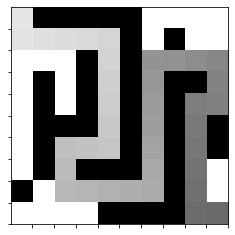

In [6]:
env = Maze(row=10, col=10, epsilon=0.1, gamma=0.99, lr=0.5, episode_len=200, mode="Q-Learning")
#env = Maze(row=10, col=10, epsilon=0.1, gamma=0.99, lr=0.9, episode_len=200, mode="Sarsa")
env.run_episode(start_row=0, start_col=0)